<a href="https://colab.research.google.com/github/PhanThanhSum/C1025L1-JV105/blob/main/training_l%E1%BA%A7n_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ===============================
# 🔧 1️⃣ Cài đặt và import thư viện
# ===============================
!pip install timm tqdm --quiet

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from tqdm import tqdm
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [ ]:
import os

# Liệt kê toàn bộ thư mục input của Kaggle
print(os.listdir("/kaggle/input/dataset/Dataset_Final"))

['Validate', 'Test', 'Train']


In [ ]:
# ===============================
# ⚙️ 2️⃣ Thiết lập thông số cơ bản
# ===============================
# Kaggle dataset được tự động mount vào /kaggle/input/<dataset_name>
DATA_DIR = "/kaggle/input/dataset/Dataset_Final"  # ⚠️ đổi tên đúng theo dataset bạn đã upload
BATCH_SIZE = 32
IMG_SIZE = 224
EPOCHS = 100
LEARNING_RATE = 1e-4
NUM_CLASSES = 30
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("📁 Data dir:", DATA_DIR)
print("🖥️ Using device:", DEVICE)

📁 Data dir: /kaggle/input/dataset/Dataset_Final
🖥️ Using device: cuda


In [ ]:
# ===============================
# 🧩 3️⃣ Tạo transform cho ảnh
# ===============================
train_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
# ===============================
# 📦 4️⃣ Load dataset
# ===============================
train_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'Train'), transform=train_transform)
val_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'Validate'), transform=val_test_transform)
test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'Test'), transform=val_test_transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"📊 Dataset loaded: {len(train_dataset)} train, {len(val_dataset)} val, {len(test_dataset)} test")

📊 Dataset loaded: 17576 train, 3755 val, 3793 test


In [ ]:
# ===============================
# 🧠 5️⃣ Tạo mô hình Swin Transformer Small
# ===============================
model = create_model('swin_small_patch4_window7_224', pretrained=True, num_classes=NUM_CLASSES)
model.to(DEVICE)

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [ ]:
# ===============================
# ⚙️ 6️⃣ Cấu hình optimizer & loss
# ===============================
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)

In [ ]:
# ===============================
# 🔁 7️⃣ Hàm train & validate
# ===============================
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in tqdm(dataloader, desc="Training", leave=False):
        images, labels = images.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += torch.sum(preds == labels).item()
        total += labels.size(0)
    return running_loss / total, correct / total

def evaluate(model, dataloader, criterion):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels).item()
            total += labels.size(0)
    return running_loss / total, correct / total

In [ ]:
# ===============================
# 🚀 8️⃣ Training loop (giảm LR sau epoch 2)
# ===============================
best_acc = 0.0
train_losses, val_losses = [], []
train_accs, val_accs = [], []
patience = 3
counter = 0

for epoch in range(EPOCHS):
    if epoch == 2:
        new_lr = 1e-5
        for param_group in optimizer.param_groups:
            param_group['lr'] = new_lr
        print(f"\n🔽 Learning rate giảm xuống {new_lr} sau epoch {epoch}\n")

    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss, val_acc = evaluate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch [{epoch+1}/{EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print(f"  Current LR: {optimizer.param_groups[0]['lr']}\n")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_swinS_food.pth")
        counter = 0
    else:
        counter += 1

    if counter >= patience:
        print(f"⏹️ Early stopping triggered after {patience} epochs without improvement.")
        break

print(f"✅ Huấn luyện hoàn tất. Best validation acc: {best_acc:.4f}")

Epoch [1/100]
  Train Loss: 0.7933 | Train Acc: 0.7691
  Val   Loss: 0.4431 | Val   Acc: 0.8700
  Current LR: 0.0001



Epoch [2/100]
  Train Loss: 0.3377 | Train Acc: 0.9015
  Val   Loss: 0.4075 | Val   Acc: 0.8839
  Current LR: 0.0001


🔽 Learning rate giảm xuống 1e-05 sau epoch 2



Epoch [3/100]
  Train Loss: 0.1591 | Train Acc: 0.9584
  Val   Loss: 0.3206 | Val   Acc: 0.9121
  Current LR: 1e-05



Epoch [4/100]
  Train Loss: 0.1211 | Train Acc: 0.9676
  Val   Loss: 0.3140 | Val   Acc: 0.9148
  Current LR: 1e-05



Epoch [5/100]
  Train Loss: 0.1067 | Train Acc: 0.9726
  Val   Loss: 0.3219 | Val   Acc: 0.9132
  Current LR: 1e-05



Epoch [6/100]
  Train Loss: 0.0911 | Train Acc: 0.9773
  Val   Loss: 0.3186 | Val   Acc: 0.9156
  Current LR: 1e-05



Epoch [7/100]
  Train Loss: 0.0772 | Train Acc: 0.9821
  Val   Loss: 0.3254 | Val   Acc: 0.9156
  Current LR: 1e-05



Epoch [8/100]
  Train Loss: 0.0665 | Train Acc: 0.9847
  Val   Loss: 0.3295 | Val   Acc: 0.9140
  Current LR: 1e-05



Epoch [9/100]
  Train Loss: 0.0574 | Train Acc: 0.9863
  Val   Loss: 0.3415 | Val   Acc: 0.9126
  Current LR: 1e-05

⏹️ Early stopping triggered after 3 epochs without improvement.
✅ Huấn luyện hoàn tất. Best validation acc: 0.9156


In [ ]:
# ===============================
# 🎯 9️⃣ Đánh giá trên test set
# ===============================
model.load_state_dict(torch.load("/kaggle/working/best_swinS_food.pth"))
test_loss, test_acc = evaluate(model, test_loader, criterion)
print(f"🎯 Test Accuracy: {test_acc:.4f}")

🎯 Test Accuracy: 0.9199


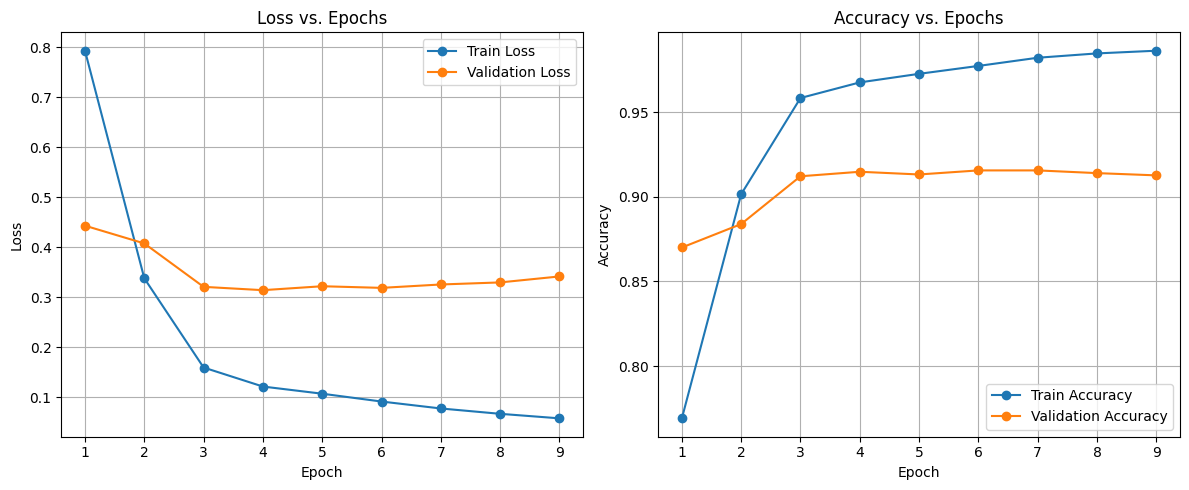

In [ ]:
# ===============================
# 📈 🔟 Vẽ biểu đồ Loss & Accuracy
# ===============================
epochs_completed = range(1, len(train_losses) + 1)
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_completed, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_completed, val_losses, label='Validation Loss', marker='o')
plt.title('Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs_completed, train_accs, label='Train Accuracy', marker='o')
plt.plot(epochs_completed, val_accs, label='Validation Accuracy', marker='o')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


🧾 Classes: ['Banh beo', 'Banh bot loc', 'Banh can', 'Banh canh', 'Banh chung', 'Banh cuon', 'Banh duc', 'Banh gio', 'Banh khot', 'Banh mi', 'Banh pia', 'Banh tet', 'Banh trang nuong', 'Banh xeo', 'Bun bo Hue', 'Bun dau mam tom', 'Bun mam', 'Bun rieu', 'Bun thit nuong', 'Ca kho to', 'Canh chua', 'Cao lau', 'Chao long', 'Com tam', 'Goi cuon', 'Hu tieu', 'Mi quang', 'Nem chua', 'Pho', 'Xoi xeo']


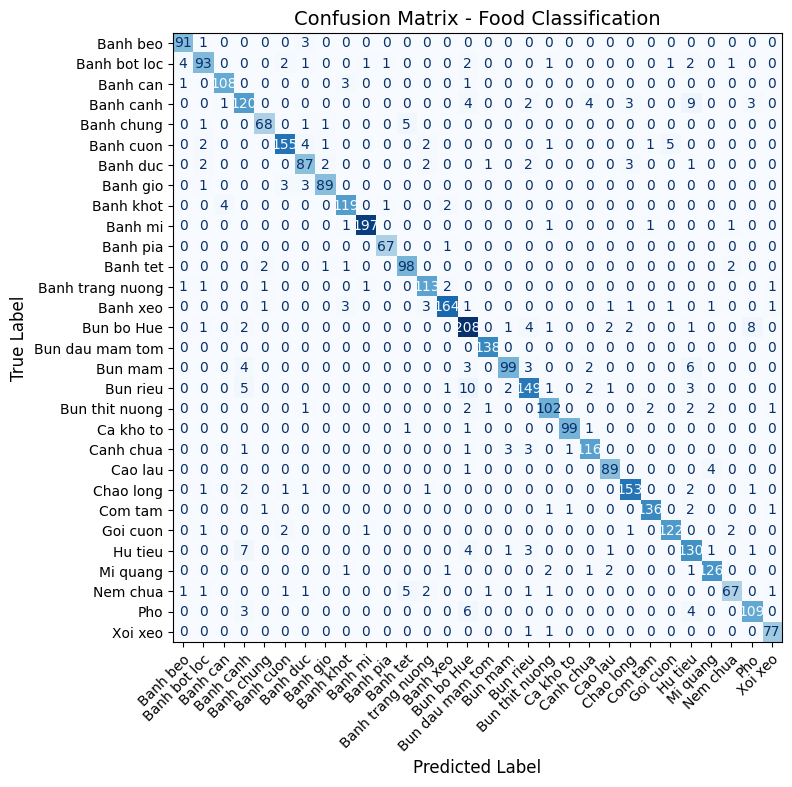

In [ ]:
# ===============================
# 🧩 11️⃣ Vẽ ma trận nhầm lẫn (Confusion Matrix)
# ===============================
train_dir = os.path.join(DATA_DIR, "Train")
class_names = sorted(os.listdir(train_dir))
print("🧾 Classes:", class_names)

all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 8))
disp.plot(cmap='Blues', values_format='d', ax=ax, colorbar=False)
plt.title("Confusion Matrix - Food Classification", fontsize=14)
plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
plt.tight_layout()
plt.show()
